In [5]:
import matplotlib.pyplot as plt
import numpy as np

from alns import ALNS, State
from alns.accept import *
from alns.select import *
from alns.stop import *

%matplotlib inline

In [6]:
SEED = 42
np.random.seed(SEED)

In [7]:
n = 100
p = np.random.randint(1, 100, size=n)
w = np.random.randint(10, 50, size=n)
W = 1_000

# Percentage of items to remove in each iteration
destroy_rate = .25

In [8]:
class KnapsackState(State):
    """
    Solution class for the 0/1 knapsack problem. It stores the current
    solution as a vector of binary variables, one for each item.
    """

    def __init__(self, x: np.ndarray):
        self.x = x

    def objective(self) -> int:
        # Negative p since ALNS expects a minimisation problem.
        return -p @ self.x

    def weight(self) -> int:
        return w @ self.x

In [9]:
def to_destroy(state: KnapsackState) -> int:
    return int(destroy_rate * state.x.sum())

def random_remove(state: KnapsackState, rnd_state):
    probs = state.x / state.x.sum()
    to_remove = rnd_state.choice(np.arange(n), size = to_destroy(state), p = probs)

    assignments = state.x.copy()
    assignments[to_remove] = 0

    return KnapsackState(x=assignments)

def worst_remove(state: KnapsackState, rnd_state):
    merit = state.x * p / w
    by_merit = np.argsort(-merit)
    by_merit = by_merit[by_merit > 0]
    to_remove = by_merit[:to_destroy(state)]

    assignments = state.x.copy()
    assignments[to_remove] = 0

    return KnapsackState(x=assignments)

In [10]:
def random_repair(state: KnapsackState, rnd_state):
    unselected = np.argwhere(state.x == 0)
    rnd_state.shuffle(unselected)

    while True:
        can_insert = w[unselected] <= W - state.weight()
        unselected = unselected[can_insert]

        if len(unselected) != 0:
            insert, unselected = unselected[0], unselected[1:]
            state.x[insert] = 1
        else:
            return state

In [11]:
def make_alns() -> ALNS:
    rnd_state = np.random.RandomState(SEED)
    alns = ALNS(rnd_state)

    alns.add_destroy_operator(random_remove)
    alns.add_destroy_operator(worst_remove)

    alns.add_repair_operator(random_repair)

    return alns

In [12]:
# Terrible - but simple - first solution, where only the first item is
# selected.
init_sol = KnapsackState(np.zeros(n))
init_sol.x[0] = 1

In [13]:
accept = HillClimbing()

In [14]:
select = RouletteWheel(scores=[5, 2, 1, 0.5],
                       decay=0.8,
                       num_destroy=2,
                       num_repair=1)

alns = make_alns()
res = alns.iterate(init_sol, select, accept, MaxIterations(10_000))

print(f"Found solution with objective {-res.best_state.objective()}.")

Found solution with objective 2776.0.


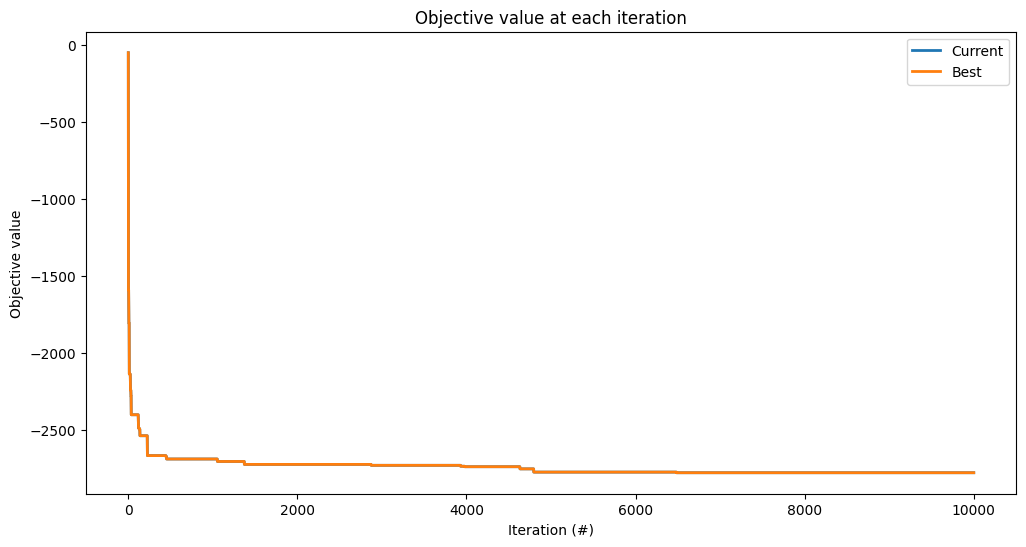

In [15]:
_, ax = plt.subplots(figsize=(12, 6))
res.plot_objectives(ax=ax, lw=2)